# Report: Towards Robust Interpretability with Self-Explaining Neural Networks

Authors: *Rico Mossinkoff, Yke Rusticus, Roberto Schiavone, Ewoud Vermeij*

## Introduction

In [1]:
import warnings
warnings.filterwarnings("ignore")

from api import mnist, compas
from api.load import load_compas, load_mnist, RegLambda, HType, NConcepts
from api.utils import MNIST_TEST_SET, COMPAS_TEST_SET, plot_accuracy_comparison

100%|██████████| 6172/6172 [00:09<00:00, 656.55it/s]


### MNIST
For the MNIST dataset, it is possible to load various models specifying the following parameters to the `load_mnist` function:
- `h_type=HType.INPUT` and `reg_lambda`
- `h_type=HType.CNN`, `reg_lambda` and `n_concepts`

If `load_mnist` is called with `h_type=HType.INPUT` and `n_concepts`, `n_concepts` is safely ignored.

The default parameters for MNIST are `h_type=HType.INPUT`, `n_concepts=NConcepts.FIVE` and `reg_lambda=RegLambda.E4`

The possible values for each parameter are shown below.

In [2]:
print('h_type possible values:')
for x in HType:
    print(x)

h_type possible values:
HType.CNN
HType.INPUT


In [3]:
print('reg_lambda possible values:')
for x in RegLambda:
    value = ('{:0.0e}' if x.value != 0 and x.value != 1 else '{}').format(x.value)
    print(str(x) + ': ' + value)

reg_lambda possible values:
RegLambda.ZERO: 0
RegLambda.E4: 1e-04
RegLambda.E3: 1e-03
RegLambda.E2: 1e-02
RegLambda.E1: 1e-01
RegLambda.ONE: 1


In [4]:
print('n_concepts possible values:')
for x in NConcepts:
    print(str(x) + ': ' + str(x.value))

n_concepts possible values:
NConcepts.FIVE: 5
NConcepts.TWENTY: 20


In [5]:
for x in RegLambda:
    print(x)

RegLambda.ZERO
RegLambda.E4
RegLambda.E3
RegLambda.E2
RegLambda.E1
RegLambda.ONE


In [6]:
import torch
torch.manual_seed(0)

In [7]:
#create model dictionaries in which we load each model configuration
compas_models = {}
mnist_input_models = {}
mnist_cnn_5concepts_models = {}
mnist_cnn_20concepts_models = {}

for l in RegLambda:
    compas_models[l.name] = load_compas(reg_lambda=l, show_specs=False)
    mnist_input_models[l.name] = load_mnist(reg_lambda=l, h_type=HType.INPUT, show_specs=False)
    mnist_cnn_5concepts_models[l.name] = load_mnist(reg_lambda=l, show_specs=False)
    mnist_cnn_20concepts_models[l.name] = load_mnist(reg_lambda=l, n_concepts=NConcepts.TWENTY, show_specs=False)

## Reproducibility

### Accuracy

👉😎👉

In [9]:
#for each model configuration, compute test accuracy and save in dictionaries (takes ~2min)
compas_accuracy = {}
mnist_input_accuracy = {}
mnist_cnn_5concepts_accuracy = {}
mnist_cnn_20concepts_accuracy = {}

for l in RegLambda:
    compas_accuracy[l.name] = compas.evaluate(compas_models[l.name], COMPAS_TEST_SET, print_freq=0)
    mnist_input_accuracy[l.name] = mnist.evaluate(mnist_input_models[l.name], MNIST_TEST_SET, print_freq=0)
    mnist_cnn_5concepts_accuracy[l.name] = mnist.evaluate(mnist_cnn_5concepts_models[l.name], MNIST_TEST_SET, print_freq=0)
    mnist_cnn_20concepts_accuracy[l.name] = mnist.evaluate(mnist_cnn_20concepts_models[l.name], MNIST_TEST_SET, print_freq=0)

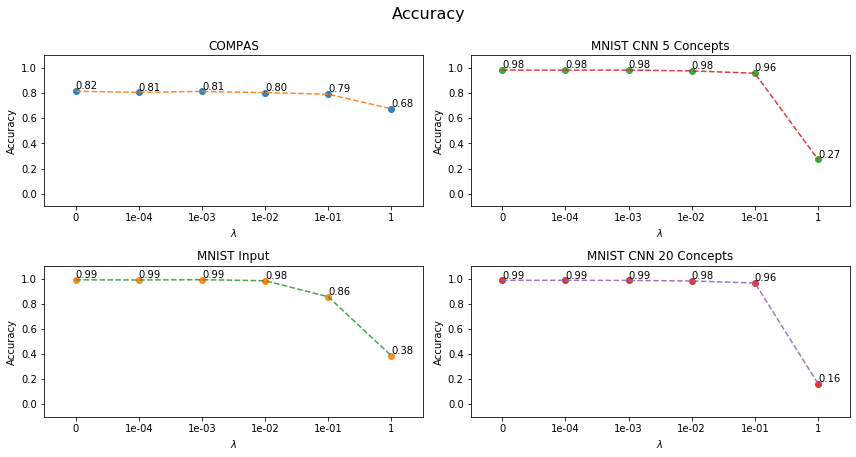

In [10]:
accuracies = [compas_accuracy, mnist_input_accuracy, mnist_cnn_5concepts_accuracy, mnist_cnn_20concepts_accuracy]
titles = ["COMPAS", "MNIST Input", "MNIST CNN 5 Concepts", "MNIST CNN 20 Concepts"]
plot_accuracy_comparison(accuracies, titles)

### Explicitness/Intelligibility

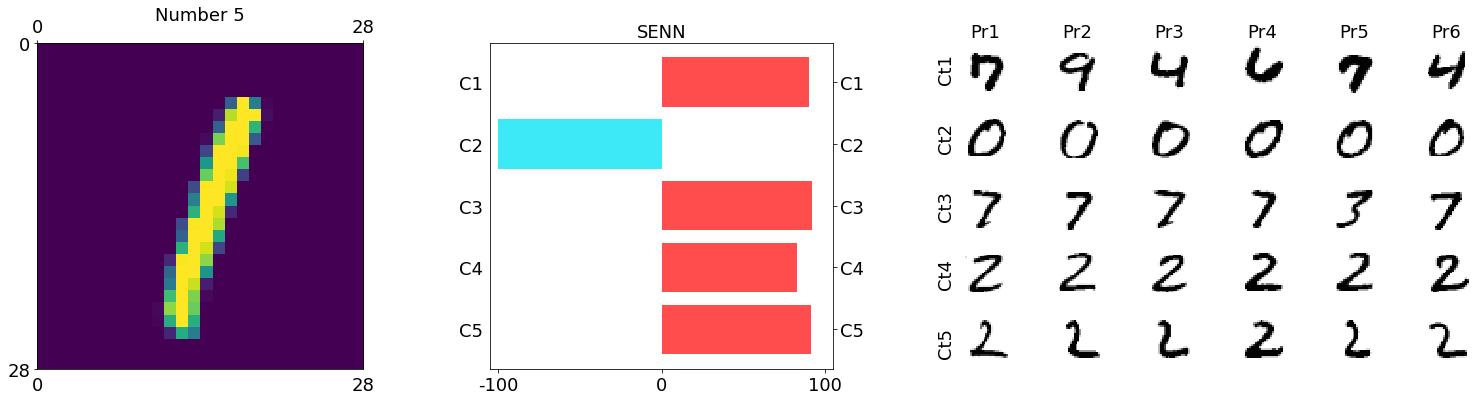

In [11]:
index = 5
mnist.im_act_con_plot(mnist_cnn_5concepts_models['E1'], index, layout='horizontal')

Setting up visualizations...


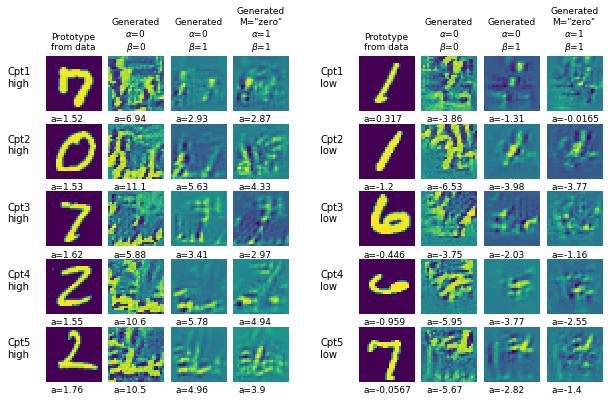

In [12]:
#takes ~2 min
prototypes = mnist.visualize_cpts(mnist_cnn_5concepts_models['E1'], MNIST_TEST_SET, p1=[0,0,1], p2=[0,1,1],
                   method=["zero"] * 3,
                   x0=None,
                   show_loss=False,
                   print_freqs=[0, 0],
                   show_activations=True,
                   return_prototypes=True,
                   best_of=1,
                   compact=False)

### Faithfulness

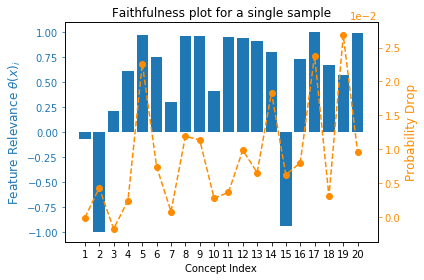

In [13]:
index = 36
mnist.faithfullness_plot(mnist_cnn_20concepts_models['E1'], MNIST_TEST_SET, index, show_h=False, show_htheta=False)

### Stability

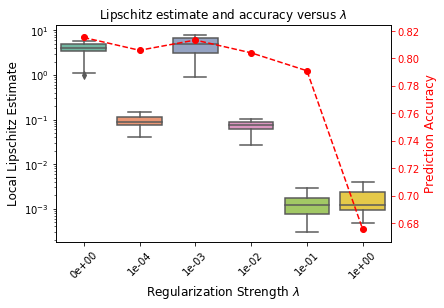

In [14]:
compas.lipschitz_accuracy_plot(models=list(compas_models.values()), 
                       reg_lambdas=[l for l in RegLambda],
                        dataset=COMPAS_TEST_SET,
                        accuracies=list(compas_accuracy.values())
                       )

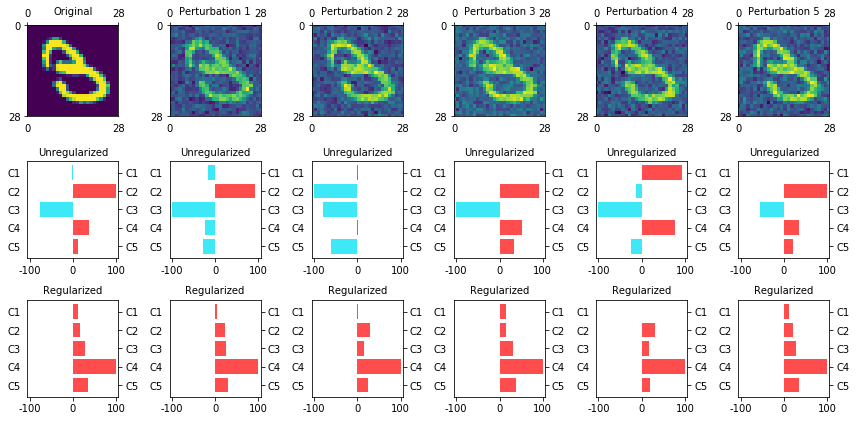

In [15]:
index = 18
model = mnist_cnn_5concepts_models[RegLambda.E1.name]
unregularized_model = mnist_cnn_5concepts_models[RegLambda.ZERO.name]
mnist.plot_digit_noise_activation_regularized_unregularized(model, unregularized_model, index, 5)

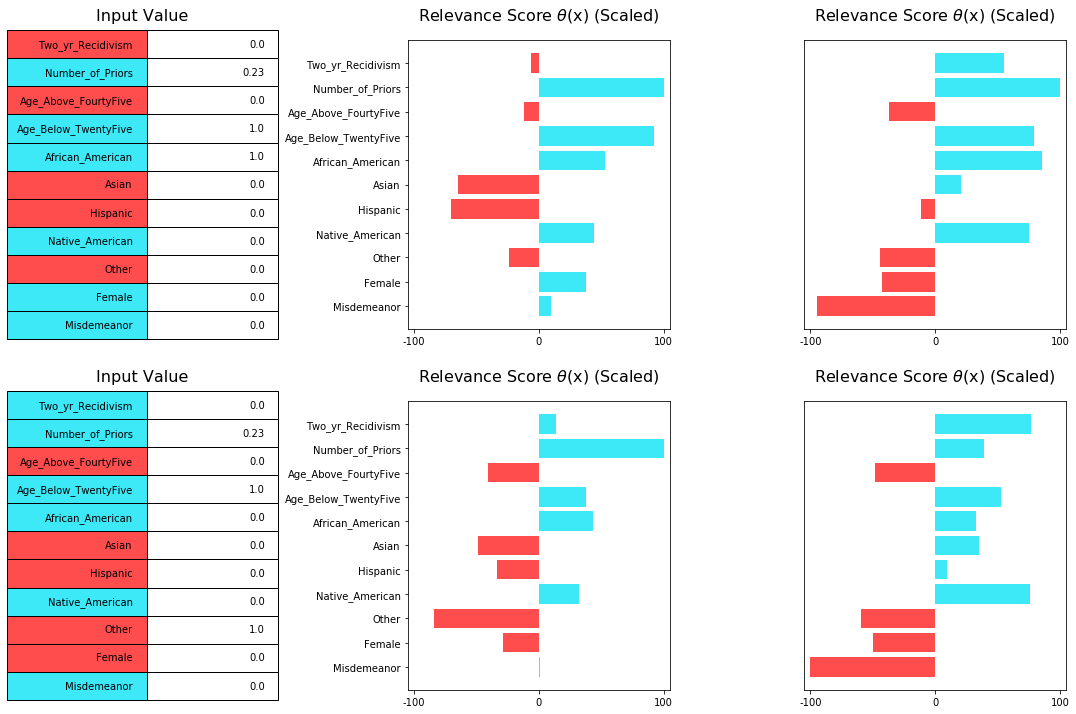

In [17]:
x = [
    0.,   # Two_yr_Recidivism
    0.23, # Number_of_Priors
    0.,   # Age_Above_FourtyFive
    1.,   # Age_Below_TwentyFive
    1.,   # African_American
    0.,   # Asian
    0.,   # Hispanic
    0.,   # Native_American
    0.,   # Other
    0.,   # Female
    0.,   # Misdemeanor
    ]

y = [
    0.,   # Two_yr_Recidivism
    0.23, # Number_of_Priors
    0.,   # Age_Above_FourtyFive
    1.,   # Age_Below_TwentyFive
    0.,   # African_American
    0.,   # Asian
    0.,   # Hispanic
    0.,   # Native_American
    1.,   # Other
    0.,   # Female
    0.,   # Misdemeanor
    ]

model = compas_models[RegLambda.E1.name]
unregularized_model = compas_models[RegLambda.ZERO.name]
compas.plot_input_values_regularized_unregularized_explanation(model, unregularized_model, [x, y])